# T3

# policy gradient

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import gym
from torch.optim import AdamW

c:\Users\jose.luis.cadiz\Anaconda3\envs\Ti_RL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Policy**

In [2]:
class Policy(nn.Module):
    def __init__(self, dim_states, dim_actions, continuous_control):
        super(Policy, self).__init__()
        # Capas completamente conectadas con activación ReLU
        self.fc1 = nn.Linear(dim_states, 64)
        self.fc2 = nn.Linear(64, 64)
        # Capa de salida lineal
        self.fc3 = nn.Linear(64, dim_actions)
        
        if continuous_control:
            # Parámetro entrenable para la desviación estándar
            self.log_std = nn.Parameter(torch.zeros(1, dim_actions))

    def forward(self, state):

         # tensor format
        if isinstance(state, torch.Tensor):
            state=state
            
        else:
            state = torch.from_numpy(state).unsqueeze(dim=0).float()


        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        
        # Si las acciones son continuas, muestrear desde una distribución normal
        if hasattr(self, "log_std"):
            std = torch.exp(self.log_std)
            dist = torch.distributions.Normal(logits, std)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            # Asegurarse de que las acciones están dentro del rango [-1, 1]
            action = torch.tanh(action)
            return action
        # Si las acciones son discretas, muestrear de una distribución categórica
        else:
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            return action

In [3]:
class Policy(nn.Module):
    
    def __init__(self, dim_states, dim_actions, continuous_control):
        super(Policy, self).__init__()
        # MLP, fully connected layers, ReLU activations, linear ouput activation
        # dim_states -> 64 -> 64 -> dim_actions

        self.layers = nn.Sequential(
            nn.Linear(dim_states, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dim_actions)
        )
        
        if continuous_control:
            # trainable parameter
            self.log_std = nn.Parameter(torch.zeros(1, dim_actions))


    def forward(self, input):

        # tensor format
        if isinstance(input, torch.Tensor):
            input=input
            
        else:
            input = torch.from_numpy(input).unsqueeze(dim=0).float()
            
        value = self.layers(input)

        return value


In [4]:
env = gym.make('Pendulum-v1')
dim_states = env.observation_space.shape[0]
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n
print(dim_states, dim_actions,continuous_control)

3 1 True


In [5]:
RN_policy= Policy(dim_states, dim_actions,continuous_control)
RN_policy

Policy(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
RN_policy.log_std

Parameter containing:
tensor([[0.]], requires_grad=True)

In [7]:
s_t=env.reset()
s_t

array([ 0.81001085, -0.58641493,  0.8076342 ], dtype=float32)

In [8]:
action=RN_policy(s_t)
action

tensor([[0.0350]], grad_fn=<AddmmBackward>)

**Policy Gradients**

In [103]:
class PolicyGradients:
    
    def __init__(self, dim_states, dim_actions, lr, gamma, 
                 continuous_control=False, reward_to_go=False, use_baseline=False):
        
        self._learning_rate = lr
        self._gamma = gamma
        
        self._dim_states = dim_states
        self._dim_actions = dim_actions

        self._continuous_control = continuous_control
        self._use_reward_to_go = reward_to_go
        self._use_baseline = use_baseline

        self._policy = Policy(self._dim_states, self._dim_actions, self._continuous_control)
        # Adam optimizer
        self._optimizer = AdamW(self._policy.parameters(), lr=self._learning_rate)

        self._select_action = self._select_action_continuous if self._continuous_control else self._select_action_discrete
        self._compute_loss = self._compute_loss_continuous if self._continuous_control else self._compute_loss_discrete


    def select_action(self, observation):
        return self._select_action(observation)
        

    def _select_action_discrete(self, observation):
        # sample from categorical distribution
        RN_policy=self._policy 
        logits=RN_policy(observation)

        # Probabilidad de cada acción
        probs = torch.softmax(logits, dim=-1)

        # Distribución de probabilidad categorica
        dist = torch.distributions.Categorical(probs)

        # Sample de acción
        action = dist.sample()
     
        return action


    def _select_action_continuous(self, observation):
        # sample from normal distribution
        # use the log std trainable parameter

        # RN
        RN_policy=self._policy

        # Parametro log std de la RN
        log_std=RN_policy.log_std
        std = torch.exp(log_std)

        # Politica dada la observación (Representa el promedio de la distribución normal que muestrea acciones)
        policy=RN_policy(observation)
        
        # Distribución normal de parametros mean y std, esta se utiliza para muestrear acciones de modo de tal de explorar el espacio de acciones
        dist = torch.distributions.Normal(policy, std)

        # sample de acción
        action = dist.sample()
        
        # Asegurarse de que las acciones están dentro del rango [-1, 1]
        action = torch.tanh(action)
        
        return action
            

    def update(self, observation_batch, action_batch, advantage_batch):
        # update the policy here
        # you should use self._compute_loss 

        pass
    

    def _compute_loss_discrete(self, observation_batch, action_batch, advantage_batch):
        # use negative logprobs * advantages
        pass


    def _compute_loss_continuous(self, observation_batch, action_batch, advantage_batch):
        # use negative logprobs * advantages
        pass

    
    def estimate_returns(self, rollouts_rew):
        estimated_returns = []
        for rollout_rew in rollouts_rew:
                
            if self._use_reward_to_go:
                # only for part 2
                estimated_return = None
            else:
                estimated_return = None
            
            estimated_returns = np.concatenate([estimated_returns, estimated_return])

        if self._use_baseline:
            # only for part 2
            average_return_baseline = None
            # Use the baseline:
            #estimated_returns -= average_return_baseline

        return np.array(estimated_returns, dtype=np.float32)


    # It may be useful to discount the rewards using an auxiliary function [optional]
    def _discount_rewards(self, rewards):
        pass


# train agent

In [1]:
import gym
import time
import datetime
import csv

import numpy as np

import matplotlib.pyplot as plt

from policy_gradients import PolicyGradients


def perform_single_rollout(env, agent, episode_nb, render=False):

    # Modify this function to return a tuple of numpy arrays containing (observations, actions, rewards).
    # (np.array(obs), np.array(acs), np.array(rws))
    # np.array(obs) -> shape: (time_steps, nb_obs)
    # np.array(acs) -> shape: (time_steps, nb_acs) if actions are continuous, (time_steps,) if actions are discrete
    # np.array(rws) -> shape: (time_steps,)

    ob_t = env.reset()
    
    done = False
    episode_reward = 0
    nb_steps = 0

    while not done:

        if render:
            env.render()
            time.sleep(1. / 60)

        action = agent.select_action(ob_t)

        ob_t1, reward, done, _ = env.step(action)

        ob_t = np.squeeze(ob_t1) # <-- may not be needed depending on gym version
        episode_reward += reward
        
        nb_steps += 1

        if done:
            return None


def sample_rollouts(env, agent, training_iter, min_batch_steps):

    sampled_rollouts = []
    total_nb_steps = 0
    episode_nb = 0
    
    while total_nb_steps < min_batch_steps:

        episode_nb += 1
        render = training_iter%10 == 0 and len(sampled_rollouts) == 0 # Change training_iter%10 to any number you want

        # Use perform_single_rollout to get data 
        # Uncomment once perform_single_rollout works.
        # Return sampled_rollouts
        """
        sample_rollout = perform_single_rollout(env, agent, episode_nb, render=render)
        total_nb_steps += len(sample_rollout[0])

        sampled_rollouts.append(sample_rollout)
        """
    return None


def train_pg_agent(env, agent, training_iterations, min_batch_steps):

    tr_iters_vec, avg_reward_vec, std_reward_vec, avg_steps_vec, std_steps_vec = [], [], [], [], []
    _, (axes) = plt.subplots(1, 2, figsize=(12,4))

    
    for tr_iter in range(training_iterations):
        # Sample rollouts using sample_rollouts
        sampled_rollouts = None

        # Parse sampled observations, actions and reward into three arrays:
        # performed_batch_steps >= min_batch_steps
        # sampled_obs: Numpy array, shape: (performed_batch_steps, dim_observations)
        sampled_obs = None
        # sampled_acs: Numpy array, shape: (performed_batch_steps, dim_actions) if actions are continuous, (performed_batch_steps,) if actions are discrete
        sampled_acs = None
        # sampled_rew: standard array of length equal to the number of trayectories that were sampled.
        # You may change the shape of sampled_rew, but it is useful keeping it as is to estimate returns.
        sampled_rew = None

        # Return estimation
        # estimated_returns: Numpy array, shape: (performed_batch_steps, )
        estimated_returns = agent.estimate_returns(sampled_rew)

        # performance metrics
        update_performance_metrics(tr_iter, sampled_rollouts, axes, tr_iters_vec, avg_reward_vec, std_reward_vec, avg_steps_vec, std_steps_vec)

        agent.update(sampled_obs, sampled_acs, estimated_returns)
    
    save_metrics(tr_iters_vec,avg_reward_vec, std_reward_vec)
    

def update_performance_metrics(tr_iter, sampled_rollouts, axes, tr_iters_vec, avg_reward_vec, std_reward_vec, avg_steps_vec, std_steps_vec):

    raw_returns     = np.array([np.sum(rollout[2]) for rollout in sampled_rollouts])
    rollout_steps   = np.array([len(rollout[2]) for rollout in sampled_rollouts])

    avg_return = np.average(raw_returns)
    max_episode_return = np.max(raw_returns)
    min_episode_return = np.min(raw_returns)
    std_return = np.std(raw_returns)
    avg_steps = np.average(rollout_steps)
    std_steps = np.std(rollout_steps)

    # logs 
    print('-' * 32)
    print('%20s : %5d'   % ('Training iter'     ,(tr_iter + 1)          ))
    print('-' * 32)
    print('%20s : %5.3g' % ('Max episode return', max_episode_return    ))
    print('%20s : %5.3g' % ('Min episode return', min_episode_return    ))
    print('%20s : %5.3g' % ('Return avg'        , avg_return            ))
    print('%20s : %5.3g' % ('Return std'        , std_return            ))
    print('%20s : %5.3g' % ('Steps avg'         , avg_steps             ))
    print('%20s : %5.3g' % ('Steps std'         , std_steps             ))

    avg_reward_vec.append(avg_return)
    std_reward_vec.append(std_return)

    avg_steps_vec.append(avg_steps)
    std_steps_vec.append(std_steps)

    tr_iters_vec.append(tr_iter)

    plot_performance_metrics(axes, 
                            tr_iters_vec, 
                            avg_reward_vec, 
                            std_reward_vec, 
                            avg_steps_vec,
                            std_steps_vec)


def plot_performance_metrics(axes, tr_iters_vec, avg_reward_vec, std_reward_vec, avg_steps_vec, std_steps_vec):
    ax1, ax2 = axes
    
    [ax.cla() for ax in axes]
    ax1.errorbar(tr_iters_vec, avg_reward_vec, yerr=std_reward_vec, marker='.',color='C0')
    ax1.set_ylabel('Avg Reward')
    ax2.errorbar(tr_iters_vec, avg_steps_vec, yerr=std_steps_vec, marker='.',color='C1')
    ax2.set_ylabel('Avg Steps')

    [ax.grid('on') for ax in axes]
    [ax.set_xlabel('training iteration') for ax in axes]
    plt.pause(0.05)


def save_metrics(tr_iters_vec, avg_reward_vec, std_reward_vec):
    with open('metrics'+datetime.datetime.now().strftime('%H:%M:%S')+'.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter='\t')
        csv_writer.writerow(['steps', 'avg_reward', 'std_reward'])
        for i in range(len(tr_iters_vec)):
            csv_writer.writerow([tr_iters_vec[i], avg_reward_vec[i], std_reward_vec[i]])


c:\Users\jose.luis.cadiz\Anaconda3\envs\Ti_RL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
env = gym.make('Pendulum-v1')

dim_states = env.observation_space.shape[0]

continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n

In [5]:
env.reset()

array([ 0.03680165,  0.9993226 , -0.41511407], dtype=float32)

In [10]:
env.render()

True

TypeError: 'NoneType' object is not iterable

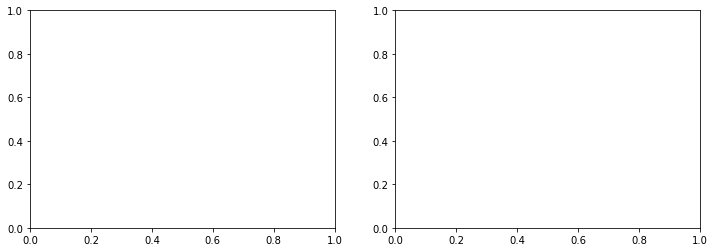

In [11]:


policy_gradients_agent = PolicyGradients(dim_states=dim_states, 
                                            dim_actions=dim_actions, 
                                            lr=0.005,
                                            gamma=0.99,
                                            continuous_control=continuous_control,
                                            reward_to_go=False,
                                            use_baseline=False)

train_pg_agent(env=env, 
                agent=policy_gradients_agent, 
                training_iterations=1000,
                min_batch_steps=5000)